<a href="https://colab.research.google.com/github/AdamHuang0402/MLclass0423/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 遷移學習 CNN(特徵抓取)(眼睛)， 用別人的，MLP(辨認)(腦袋)用自己的 
# 圖片小，用比較少層就好
%tensorflow_version 2.x

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, y_train), (x_test, y_test) = load_data()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
trans = [
"airplane",										
"automobile",										
"bird",										
"cat",										
"deer",										
"dog",										
"frog",										
"horse",										
"ship",										
"truck"										
]

horse


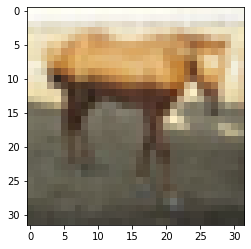

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = 2000
print(trans[y_train[idx][0]])
plt.imshow(x_train[idx])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

layers = [
    # 27(1 filter) * 64 + 64(bias) = 1792
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    # 576(1 filter) * 128 + 128(bias) = 73856
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.25),
    Dense(10, activation="softmax")
]
model = Sequential(layers=layers)
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [ ]:
# Sparse 會做 one High encoding，所以不用做，直接 call 即可
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [ ]:
# earlyStopping loss 變不好即停止
# 存模型: model.save("xxx.h5")
# 讀取模型:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("cnn.h5", save_best_only=True)
]
model.fit(x_train_norm,
          y_train,
          batch_size=200,
          epochs=100,
          validation_split=0.1,
          verbose=2,
          callbacks=callbacks)

Epoch 1/100
225/225 - 3s - loss: 0.3716 - accuracy: 0.8685 - val_loss: 0.6913 - val_accuracy: 0.7802
Epoch 2/100
225/225 - 2s - loss: 0.3214 - accuracy: 0.8871 - val_loss: 0.7112 - val_accuracy: 0.7868
Epoch 3/100
225/225 - 3s - loss: 0.2856 - accuracy: 0.9003 - val_loss: 0.7079 - val_accuracy: 0.7848
Epoch 4/100
225/225 - 2s - loss: 0.2349 - accuracy: 0.9162 - val_loss: 0.8218 - val_accuracy: 0.7754


In [ ]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7128 - accuracy: 0.7627


[0.712762713432312, 0.7627000212669373]

In [ ]:
pre = model.predict_classes(x_test_norm)
pre

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([3, 8, 8, ..., 5, 4, 7])

In [ ]:
# 轉換同樣的維度
print(pre.shape)
print(y_test.shape)
y_test_reshape = y_test.reshape(-1)
print(y_test_reshape.shape)

(10000,)
(10000, 1)
(10000,)


In [ ]:
# 不是在tf裡, 帶入原本的y
import pandas as pd
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_reshape, pre)
c = ["{}(預測)".format(i) for i in trans]
i = ["{}(真實)".format(i) for i in trans]
pd.DataFrame(mat, columns=c, index=i)

,airplane(預測),automobile(預測),bird(預測),cat(預測),deer(預測),dog(預測),frog(預測),horse(預測),ship(預測),truck(預測)
airplane(真實),795,15,54,24,17,7,17,7,37,27
automobile(真實),14,851,10,16,3,4,14,1,13,74
bird(真實),47,3,657,51,74,57,85,13,8,5
cat(真實),10,2,70,611,65,128,90,13,4,7
deer(真實),11,3,65,62,722,30,70,29,7,1
dog(真實),5,1,46,170,41,667,33,26,6,5
frog(真實),4,2,26,38,15,11,898,1,1,4
horse(真實),5,2,39,54,68,54,14,757,2,5
ship(真實),49,27,17,27,7,4,16,1,828,24
truck(真實),21,55,13,25,3,12,12,8,10,841


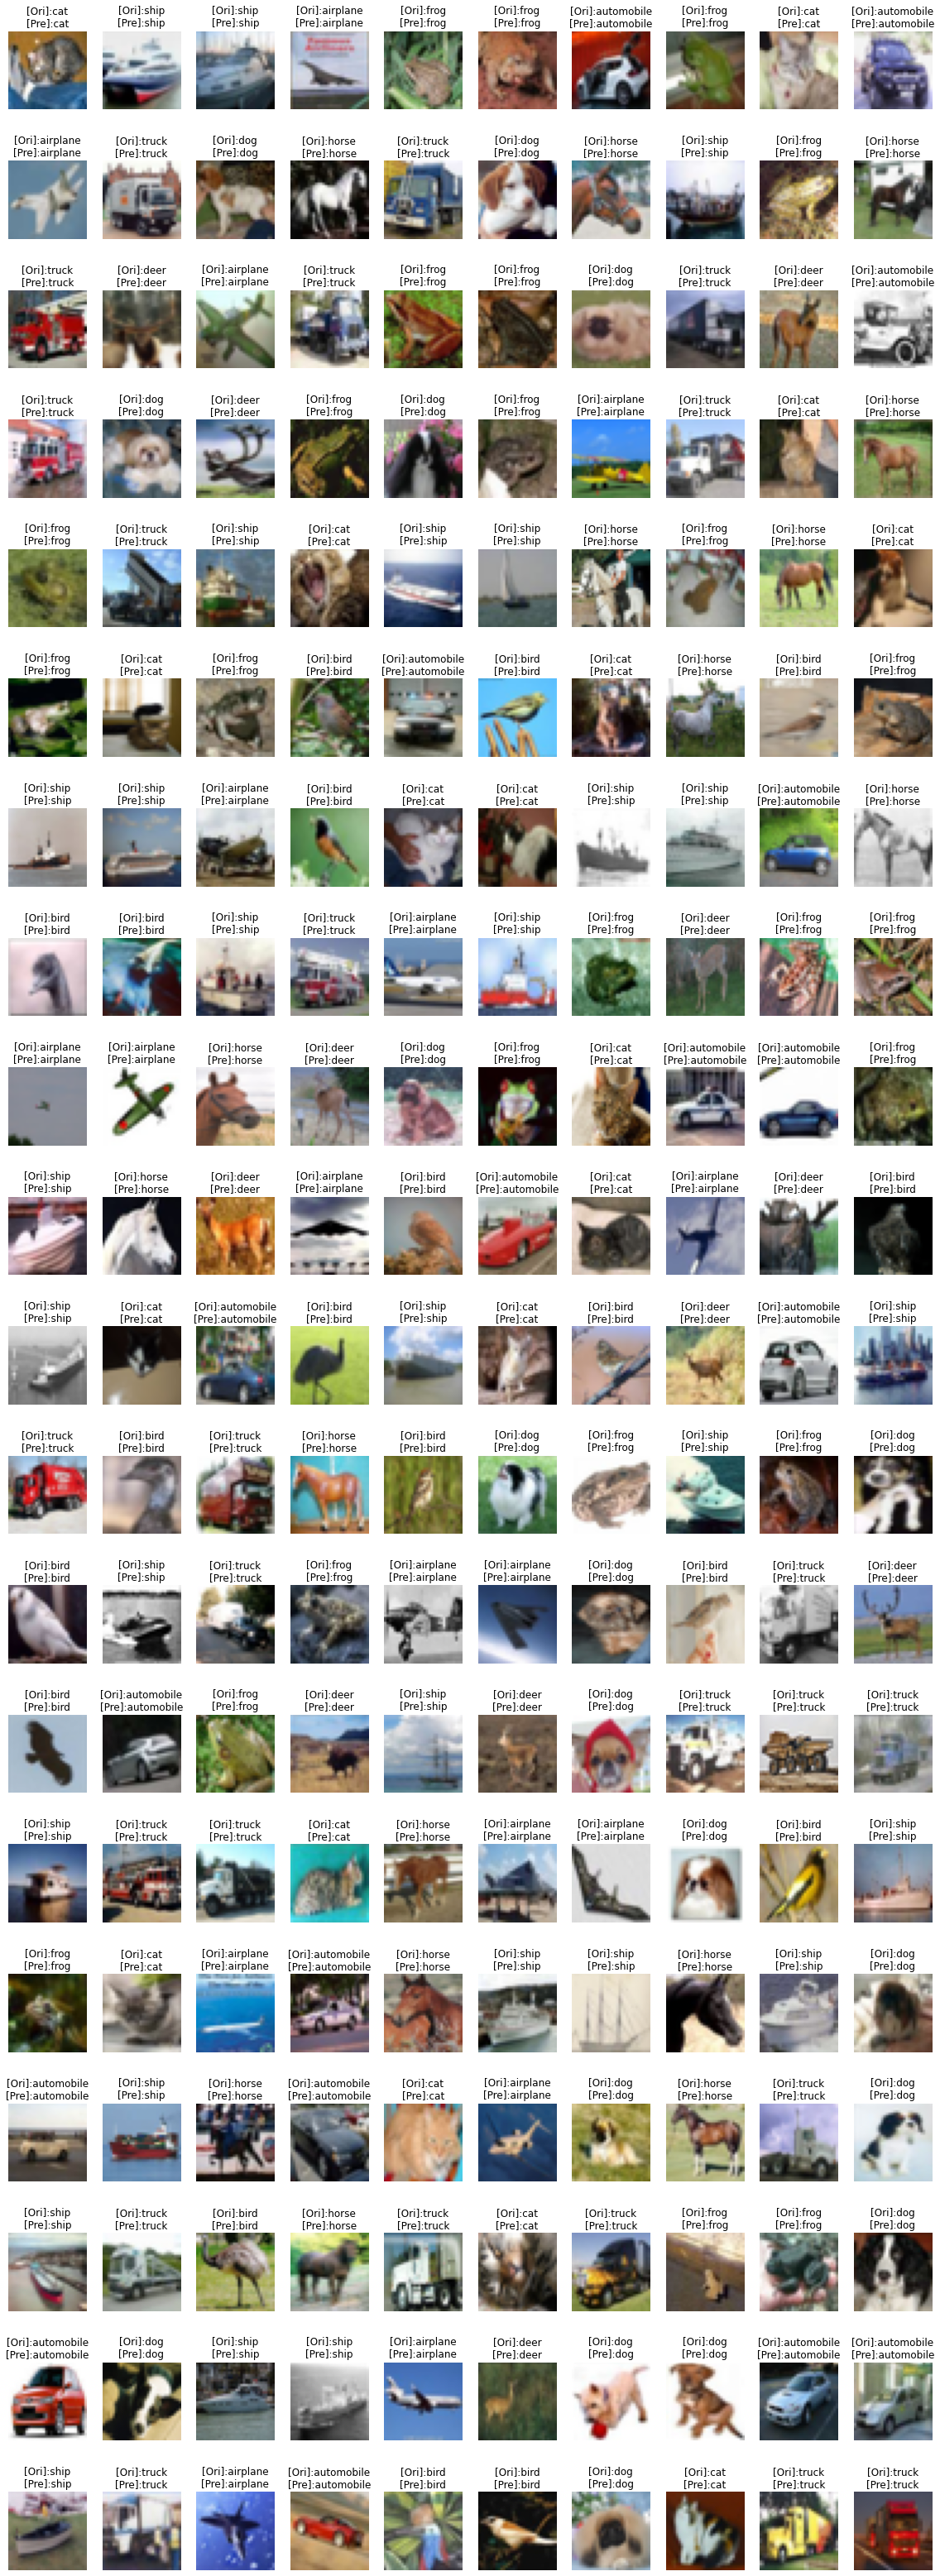

In [ ]:
import numpy as np
# nonzero: 取出是True的index
# (x座標, y座標, z座標)

# # 預測錯誤的圖
# idx = np.nonzero(pre != y_test_reshape)[0]
# idx = idx[:200]
# false_img = x_test[idx]
# false_answer = y_test_reshape[idx]
# false_predict = pre[idx]

# # 預測正確的圖
idx = np.nonzero(pre == y_test_reshape)[0]
idx = idx[:200]
false_img = x_test[idx]
false_answer = y_test_reshape[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 60))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)

輸入檔名:cat.jpg
應該是: cat


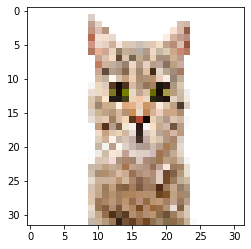

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
fn = input("輸入檔名:")
img = load_img(fn, target_size=(32, 32))
# 剛剛帶入 (10000, 784)
# 現在帶入 (1, 784)
img_norm = np.array(img).reshape(1, 32, 32, 3) / 255
ans = model.predict_classes(img_norm)[0]
print("應該是:", trans[ans])
plt.imshow(img)

In [ ]:

# 讀取model
from tensorflow.keras.models import load_model
loaded = load_model("cnn.h5") 
# 讀取完以後 1. predict 2. fit(不用compile)
loaded.evaluate(x_test_norm, y_test)
# 如果你想看h5 https://support.hdfgroup.org/products/java/release/download.html

313/313 [==============================] - 2s 6ms/step - loss: 0.7241 - accuracy: 0.7568


[0.7240639925003052, 0.7567999958992004]